In [52]:
%tensorflow_version 1.x

In [53]:
import os
import numpy as np
import random
import re
import string
import tensorflow as tf
import zipfile
import pickle
import matplotlib.pyplot as plt

In [54]:
from google.colab import drive
drive.mount('/content/gdrive')
path_to_dataset = '/content/gdrive/My Drive/IR/icdar2019'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
def create_pairs(file, start=0):
    """
    Create sentence pairs, where first sentence is the OCR-ed sentence and 
    2nd sentence is the GS sentence or the target one. This can be viewed as Machine Translation
    task.
    """
    print("Reading lines...")

    with open(file) as f:
        data = f.readlines()

    clean_sentences_ocr = []
    clean_sentences_gs = []

    for i in range(start, len(data), 2):
      clean_sentences_ocr.append(clean_text(data[i]))
      clean_sentences_gs.append(clean_text(data[i + 1]))

    pairs = [[x, y] for x, y in zip(clean_sentences_ocr, clean_sentences_gs)]

    return pairs

In [56]:
def clean_text(text):
    text = re.sub(r'\n', '', text)

    return text.lower()

In [57]:
def prepare_data(file):
    return create_pairs(file)

input_file = path_to_dataset + '/correct_single.txt'
pairs = prepare_data(input_file)

Reading lines...


In [58]:
print("Read {} word pairs".format(len(pairs) // 2))
pair1 = random.choice(pairs)
pair2 = random.choice(pairs)
pair3 = random.choice(pairs)

print("Pair 1: OCR: {}, GS: {}, len1: {} and len2: {}".format(pair1[0], pair1[1], len(pair1[0]), len(pair1[1])))
print("Pair 2: OCR: {}, GS: {}, len1: {} and len2: {}".format(pair2[0], pair2[1], len(pair2[0]), len(pair2[1])))
print("Pair 3: OCR: {}, GS: {}, len1: {} and len2: {}".format(pair3[0], pair3[1], len(pair3[0]), len(pair3[1])))

Read 7122 word pairs
Pair 1: OCR: отъ, GS: отъ, len1: 3 and len2: 3
Pair 2: OCR: човър-, GS: човър‑, len1: 6 and len2: 6
Pair 3: OCR: ,е, GS: @ѣ, len1: 2 and len2: 2


Create a small validation set.

In [59]:
valid_size = 1000
valid_pairs = pairs[:valid_size]
train_pairs = pairs[valid_size:]

train_size = len(train_pairs)
print(train_size, train_pairs[:5])
print(valid_size, valid_pairs[:5])

13245 [['въренъ', 'вѣренъ'], ['бждн.', 'бѫди.'], ['унизи@', 'унизѝ'], ['с’', "с'"], ['измьна', 'измѣна']]
1000 [['@@@350', '   350'], ['хриету', 'христу'], ['служители;', 'служитель;'], ['кръви', 'кръвь'], ['тьло', 'тѣло']]


In [60]:
content = ''.join([p[0] + p[1] for p in pairs])

invalid_chars = set(['^', '■', '•', '~', '§', '°', '®', '&', ' ', '½', 'λ', '„', '«'])
all_chars = set(content) - invalid_chars

all_chars = list(all_chars)
print(all_chars)
print("All chars are: {}".format(len(all_chars)))

["'", '!', ']', '<', ',', '2', 'h', '.', 'л', 'р', '8', '|', '‐', '5', 'ѣ', 'м', 'у', '6', ')', 'l', '@', '‑', 'o', '0', '}', 'к', 'ц', 'm', 'ч', 'n', 'a', '[', '%', 'ῳ', '‘', '—', '’', 'б', '?', 'ю', 't', '3', 'в', 'и', 'ъ', 'я', 'г', 'п', 'γ', 'і', 'н', 'ῷ', 'z', 'j', '1', '―', 'b', 'ж', '̀', '“', ':', 'о', 'g', '\\', 'ӏ', '{', 'х', 'v', 'ӣ', '(', 'д', '"', 'τ', 'f', 'd', 'й', '>', '9', 'u', '”', 'ό', 's', 'ѫ', 'p', ';', '*', '7', 'i', '/', '4', 'т', 'x', '́', 'щ', '-', 'а', 'ѭ', 'с', '#', 'e', 'k', 'ы', 'ь', 'ш', 'з', 'ф', '»', 'c', 'r', 'е']
All chars are: 110


In [61]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    
    return len(distribution) - 1

def sample(prediction):
    """Turn a prediction into a 1-hot encoded vecotr."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0

    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b / np.sum(b, 1)[:, None]

In [62]:
from tensorflow.python.layers.core import Dense

batch_size = 128
rnn_size = 64
num_layers = 2
embedding_size = 64
learning_rate = 0.001
sequence_length = 10

In [63]:
print("Training pairs {}".format(len(train_pairs) // 2))
print("Validation pairs {}".format(len(valid_pairs) // 2))

Training pairs 6622
Validation pairs 500


In [64]:
def create_dictionaries():
    special_words = ['<PAD>', '<UNK>', '<GO>',  '<END>']

    words = all_chars + special_words
    dictionary = {word: i for i, word in enumerate(words)}

    return dictionary, dict(zip(dictionary.values(), dictionary.keys())) 

dictionary, reverse_dictionary = create_dictionaries()

print(dictionary)
print(reverse_dictionary)

x_sentences = [pair[0] for pair in train_pairs]
y_sentences = [pair[1] for pair in train_pairs]

# Convert each word to dictionary representations
x_ids = [[dictionary.get(letter, dictionary['<UNK>']) for letter in sentence] for sentence in x_sentences]
y_ids = [[dictionary.get(letter, dictionary['<UNK>']) for letter in sentence] for sentence in y_sentences]

print("Example raw data:")
print(train_pairs[:5])
print("Example sequence")
print(x_ids[:5])
print("\n")
print("Example output")
print(y_ids[:5])

{"'": 0, '!': 1, ']': 2, '<': 3, ',': 4, '2': 5, 'h': 6, '.': 7, 'л': 8, 'р': 9, '8': 10, '|': 11, '‐': 12, '5': 13, 'ѣ': 14, 'м': 15, 'у': 16, '6': 17, ')': 18, 'l': 19, '@': 20, '‑': 21, 'o': 22, '0': 23, '}': 24, 'к': 25, 'ц': 26, 'm': 27, 'ч': 28, 'n': 29, 'a': 30, '[': 31, '%': 32, 'ῳ': 33, '‘': 34, '—': 35, '’': 36, 'б': 37, '?': 38, 'ю': 39, 't': 40, '3': 41, 'в': 42, 'и': 43, 'ъ': 44, 'я': 45, 'г': 46, 'п': 47, 'γ': 48, 'і': 49, 'н': 50, 'ῷ': 51, 'z': 52, 'j': 53, '1': 54, '―': 55, 'b': 56, 'ж': 57, '̀': 58, '“': 59, ':': 60, 'о': 61, 'g': 62, '\\': 63, 'ӏ': 64, '{': 65, 'х': 66, 'v': 67, 'ӣ': 68, '(': 69, 'д': 70, '"': 71, 'τ': 72, 'f': 73, 'd': 74, 'й': 75, '>': 76, '9': 77, 'u': 78, '”': 79, 'ό': 80, 's': 81, 'ѫ': 82, 'p': 83, ';': 84, '*': 85, '7': 86, 'i': 87, '/': 88, '4': 89, 'т': 90, 'x': 91, '́': 92, 'щ': 93, '-': 94, 'а': 95, 'ѭ': 96, 'с': 97, '#': 98, 'e': 99, 'k': 100, 'ы': 101, 'ь': 102, 'ш': 103, 'з': 104, 'ф': 105, '»': 106, 'c': 107, 'r': 108, 'е': 109, '<PAD>':

In [65]:
def create_cell(rnn_size):
    cell = tf.contrib.rnn.LSTMCell(rnn_size,initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
    
    return cell

In [66]:
def get_model_inputs():
    inputs = tf.placeholder(tf.int32, [batch_size, None], name = 'inputs')
    labels = tf.placeholder(tf.int32, [batch_size, None])
    lr = tf.placeholder(tf.float32)

    input_sequence_length = tf.placeholder(tf.int32, (batch_size,), name = 'input_sequence_length')
    label_sequence_length = tf.placeholder(tf.int32, (batch_size,), name = 'label_sequence_length')
    
    max_label_sequence_length = tf.reduce_max(label_sequence_length)
    
    return inputs, labels, lr, input_sequence_length, label_sequence_length, max_label_sequence_length

In [67]:
def encoding_layer(inputs, rnn_size, num_layers, input_sequence_length, vocab_size, embedding_size):

    embedded_input = tf.contrib.layers.embed_sequence(inputs, vocab_size, embedding_size)
    encoder_cell = tf.contrib.rnn.MultiRNNCell([create_cell(rnn_size) for _ in range(num_layers)])
    encoder_output, encoder_state = tf.nn.dynamic_rnn(encoder_cell, embedded_input, sequence_length=input_sequence_length, dtype=tf.float32)
    
    return encoder_output, encoder_state

In [68]:
# Some basic preprocessing to remove the last char and add the GO symbol for the decoder
def process_decoder_input(labels, dictionary, batch_size):
    ending = tf.strided_slice(labels, [0, 0], [batch_size, -1], [1, 1])
    decoder_input = tf.concat([tf.fill([batch_size, 1], dictionary['<GO>']), ending], 1)

    return decoder_input

In [69]:
def decoding_layer(dictionary, embedding_size, num_layers, rnn_size, labels_sequence_length, max_label_sequence_length, encoder_state, decoder_input):

    vocab_size = len(dictionary)
    decoder_embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size]))
    decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings, decoder_input)

    decoder_cell = tf.contrib.rnn.MultiRNNCell([create_cell(rnn_size) for _ in range(num_layers)])
     
    output_layer = Dense(vocab_size, kernel_initializer=tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))

    with tf.variable_scope("decode"):
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=decoder_embed_input, sequence_length=labels_sequence_length, time_major=False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, training_helper, encoder_state, output_layer) 
        training_decoder_output = tf.contrib.seq2seq.dynamic_decode(training_decoder,impute_finished=True, maximum_iterations=max_label_sequence_length)[0]

    with tf.variable_scope("decode", reuse=True):
        start_tokens = tf.tile(tf.constant([dictionary['<GO>']], dtype=tf.int32), [batch_size], name='start_tokens')

        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings, start_tokens, dictionary['<END>'])
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell,inference_helper,encoder_state,output_layer)
        inference_decoder_output = tf.contrib.seq2seq.dynamic_decode(inference_decoder, impute_finished=True, maximum_iterations=max_label_sequence_length)[0]
    
    return training_decoder_output, inference_decoder_output

In [70]:
def seq2seq_model(input_data, labels, lr, inputs_sequence_length, labels_sequence_length, max_label_sequence_length, vocab_size, embedding_size, rnn_size, num_layers):
    
    _, encoder_state = encoding_layer(input_data, rnn_size, num_layers, inputs_sequence_length, vocab_size, embedding_size)
    
    decoder_input = process_decoder_input(labels, dictionary, batch_size)
    
    training_decoder_output, inference_decoder_output = decoding_layer(dictionary, embedding_size, num_layers, rnn_size, labels_sequence_length,\
                                                                       max_label_sequence_length, encoder_state, decoder_input) 
    
    return training_decoder_output, inference_decoder_output

In [71]:
train_graph = tf.Graph()

with train_graph.as_default():
    
    input_data, labels, lr, input_sequence_length, label_sequence_length, max_label_sequence_length = get_model_inputs()
    
    training_decoder_output, inference_decoder_output = seq2seq_model(input_data, labels, lr, input_sequence_length,label_sequence_length, max_label_sequence_length,\
                                                                      len(dictionary),embedding_size, rnn_size, num_layers)    

    training_logits = tf.identity(training_decoder_output.rnn_output, 'logits')
    inference_logits = tf.identity(inference_decoder_output.sample_id, name='predictions')
    
    masks = tf.sequence_mask(label_sequence_length, max_label_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):

        cost = tf.contrib.seq2seq.sequence_loss(training_logits, labels, masks)

        optimizer = tf.train.AdamOptimizer(lr)

        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

In [72]:
def pad_batch(batch, pad_int):
    # make sure each word has the same length
    max_length = max([len(word) for word in batch])
    return [word + [pad_int] * (max_length - len(word)) for word in batch]

In [73]:
class BatchGenerator(object):
    def __init__(self, labels, inputs, batch_size, input_pad_int, label_pad_int):
        self._labels = labels
        self._inputs = inputs
        self._batch_size = batch_size
        self._input_pad_int = input_pad_int
        self._label_pad_int = label_pad_int
        self._cursor = 0
  
    def next(self):
        # Generates a single batch
        start_i = self._cursor * self._batch_size
        input_batch = self._inputs[start_i:start_i + self._batch_size]
        label_batch = self._labels[start_i:start_i + self._batch_size]
        pad_input_batch = np.array(pad_batch(input_batch, self._input_pad_int))
        pad_label_batch = np.array(pad_batch(label_batch, self._label_pad_int))
        
        pad_label_lengths = []
        for i in pad_label_batch:
            pad_label_lengths.append(len(i))

        pad_input_lengths = []
        for i in pad_input_batch:
            pad_input_lengths.append(len(i))
            
        self._cursor = self._cursor + 1
        
        return pad_label_batch, pad_input_batch, pad_label_lengths, pad_input_lengths

In [74]:
train_input = x_ids[batch_size:]
train_labels = y_ids[batch_size:]

valid_input = x_ids[:batch_size]
valid_labels = y_ids[:batch_size]

batch_generator_valid = BatchGenerator(valid_labels, valid_input, batch_size, dictionary['<PAD>'], dictionary['<PAD>'])
batch_generator_train = BatchGenerator(train_labels, train_input, batch_size, dictionary['<PAD>'], dictionary['<PAD>'])


(valid_labels_batch, valid_input_batch, valid_labels_lengths, valid_input_lengths) = batch_generator_valid.next()

checkpoint = "seq2seq.ckpt"
training_epochs = 100

loss_train = []
loss_valid = []

data = []
for batch_i in range(0, len(train_input) // batch_size):
    data.append(batch_generator_train.next())


with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):

      for labels_batch, input_batch, labels_lengths, input_lengths in data:
        _, loss = sess.run([train_op, cost],
        {
            input_data: input_batch,
            labels: labels_batch,
            lr: learning_rate,
            label_sequence_length: labels_lengths,
            input_sequence_length: input_lengths
          })
        
      validation_loss = sess.run(
      [cost],
      {
          input_data: valid_input_batch,
          labels: valid_labels_batch,
          lr: learning_rate,
          label_sequence_length: valid_labels_lengths,
          input_sequence_length: valid_input_lengths
       })
      
      print('Epoch %d/%d - Loss: %.3f  - Validation loss: %.3f' % (epoch, training_epochs, loss, validation_loss[0]))
      loss_train.append(loss)
      loss_valid.append(validation_loss[0])

    # save the model state
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    print('Model Trained and Saved')

Epoch 0/100 - Loss: 1.673  - Validation loss: 1.454
Epoch 1/100 - Loss: 1.382  - Validation loss: 1.220
Epoch 2/100 - Loss: 1.321  - Validation loss: 1.154
Epoch 3/100 - Loss: 1.283  - Validation loss: 1.127
Epoch 4/100 - Loss: 1.261  - Validation loss: 1.112
Epoch 5/100 - Loss: 1.242  - Validation loss: 1.101
Epoch 6/100 - Loss: 1.225  - Validation loss: 1.088
Epoch 7/100 - Loss: 1.182  - Validation loss: 1.060
Epoch 8/100 - Loss: 1.126  - Validation loss: 1.016
Epoch 9/100 - Loss: 1.092  - Validation loss: 0.995
Epoch 10/100 - Loss: 1.078  - Validation loss: 0.983
Epoch 11/100 - Loss: 1.068  - Validation loss: 0.976
Epoch 12/100 - Loss: 1.061  - Validation loss: 0.971
Epoch 13/100 - Loss: 1.055  - Validation loss: 0.967
Epoch 14/100 - Loss: 1.049  - Validation loss: 0.963
Epoch 15/100 - Loss: 1.043  - Validation loss: 0.960
Epoch 16/100 - Loss: 1.037  - Validation loss: 0.955
Epoch 17/100 - Loss: 1.018  - Validation loss: 0.949
Epoch 18/100 - Loss: 0.988  - Validation loss: 0.936
Epo

In [75]:
saved_model_path = path_to_dataset + '/seq2seq/'

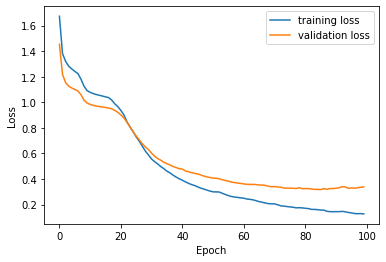

In [76]:
plt.plot(loss_train, label='training loss')
plt.plot(loss_valid, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [77]:
# with open('dictionary.pickle', 'wb') as handle:
#     pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('reverse_dictionary.pickle', 'wb') as handle:
#     pickle.dump(reverse_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
with open(saved_model_path + 'dictionary.pickle', 'rb') as handle:
    dictionary = pickle.load(handle)

with open(saved_model_path + 'reverse_dictionary.pickle', 'rb') as handle:
    reverse_dictionary = pickle.load(handle)

In [79]:
print(dictionary)

{'[': 0, '“': 1, 'f': 2, '*': 3, '#': 4, 'ц': 5, '?': 6, '”': 7, "'": 8, ',': 9, '»': 10, '"': 11, '9': 12, '‑': 13, '@': 14, '<': 15, 'с': 16, 'c': 17, 'о': 18, 'л': 19, 'п': 20, 'б': 21, 'e': 22, 'ш': 23, 'і': 24, '—': 25, 'ж': 26, ';': 27, 'е': 28, '|': 29, '̀': 30, 'r': 31, 'h': 32, 'o': 33, '1': 34, '5': 35, '3': 36, 's': 37, 'у': 38, '’': 39, 'g': 40, '―': 41, 'τ': 42, '!': 43, '>': 44, '{': 45, 'j': 46, 'ъ': 47, 'х': 48, '6': 49, 'ѭ': 50, 'ῳ': 51, 'a': 52, 'г': 53, 'к': 54, 'x': 55, ':': 56, 'ы': 57, 't': 58, 'н': 59, '́': 60, '4': 61, 'м': 62, 'з': 63, 'ь': 64, 'l': 65, 'k': 66, ']': 67, 'z': 68, 'в': 69, '\\': 70, 'ῷ': 71, 'и': 72, 'ό': 73, 'ӏ': 74, '‐': 75, '(': 76, 'щ': 77, 'i': 78, '‘': 79, 'p': 80, 'т': 81, 'а': 82, 'ф': 83, 'd': 84, '.': 85, 'n': 86, '2': 87, '/': 88, 'm': 89, 'ӣ': 90, '8': 91, 'ю': 92, 'ѫ': 93, 'р': 94, '-': 95, '0': 96, '7': 97, 'я': 98, '}': 99, ')': 100, 'γ': 101, 'й': 102, 'ѣ': 103, 'v': 104, '%': 105, 'b': 106, 'ч': 107, 'u': 108, 'д': 109, '<PAD>':

In [80]:
def to_seq(text):
    # preprocess text for the model
    return [dictionary.get(word, dictionary['<UNK>']) for word in text] + [dictionary['<PAD>']]*(sequence_length-len(text))

In [81]:
pad = dictionary["<PAD>"] 

checkpoint = path_to_dataset + '/seq2seq/seq2seq.ckpt'

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    
    # load the model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('inputs:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    input_sequence_length = loaded_graph.get_tensor_by_name('input_sequence_length:0')
    label_sequence_length = loaded_graph.get_tensor_by_name('label_sequence_length:0')
   
    # words = ['когаго']
    # words = ['когато']
    # words = ['нещо']
    # words = ['срЪдъ']
    # words = ['погрешка']
    # words = ['турилъ']
    words = ['грешка']
    # words = ['твърде']

    input_sentence = ' '.join(words)
    
    print()
    print('Original Text: %s' % input_sentence)
    print('Word Ids: %s' % ([[letter for letter in to_seq(word.lower())] for word in words]))
    inputWords = [" ".join([reverse_dictionary[i] for i in to_seq(word)]) for word in words]
    print('Input words: %s' % inputWords)
    
    print()
    print("Output:")
    outputs = list()
    for word in input_sentence.split(' '):
        word_seq = to_seq(word.lower())
        answer_logits = sess.run(logits, {input_data: [word_seq] * batch_size, label_sequence_length: [len(word_seq)] * batch_size, input_sequence_length: [len(word_seq)]*batch_size})[0]

        
        output_word = ''.join([reverse_dictionary[i] for i in answer_logits if i != pad])

        print('Word Ids: %s' % ([i for i in answer_logits if i != pad]))
        print('Response Word: %s' % (output_word))
        outputs.append(output_word)
    
    print()
    print("Sentence output: %s" % (' '.join(outputs)))

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/IR/icdar2019/seq2seq/seq2seq.ckpt

Original Text: грешка
Word Ids: [[53, 94, 28, 23, 54, 82, 110, 110, 110, 110]]
Input words: ['г р е ш к а <PAD> <PAD> <PAD> <PAD>']

Output:
Word Ids: [53, 94, 103, 23, 54, 82]
Response Word: грѣшка

Sentence output: грѣшка


In [82]:
!zip -r model.zip ./saved

	zip warning: name not matched: ./saved

zip error: Nothing to do! (try: zip -r model.zip . -i ./saved)


In [83]:
test_dataset = path_to_dataset + '/correct_sentence.txt'
test_dataset_words = path_to_dataset + '/correct_test_single.txt'
test_pairs_sentences = create_pairs(test_dataset,start=1)
test_pairs_single = create_pairs(test_dataset_words)

Reading lines...
Reading lines...


In [84]:
hackset = set()
for pair in test_pairs_single:
  hackset.add(pair[0])

print(random.sample(hackset, 10))

['живеете?', '-—', 'де', 'рхка,', 'п@б-трудолю-', 'заирещава', 'отзпвъ,', 'кадо', 'съдййствували', 'нощвитъ']


In [85]:
!pip install Levenshtein
from Levenshtein import distance as levenshtein_distance

In [86]:
def clean_up(word):
  word = re.sub(r'\n', '', word)
  word = word.replace('@', '')
  word = word.lower()
  return word.strip()

In [87]:
file_clada = path_to_dataset + '/clada.txt'
def parse_clada(file):
  clada_set = set()
  with open(file, "r", encoding="utf-16") as f:
    raw_text = f.readlines()

  for word in raw_text:
    temp = clean_up(word)
    if temp not in clada_set:
      clada_set.add(temp)

  return clada_set

clada_set = parse_clada(file_clada)
print(random.sample(clada_set, 10))
print(len(clada_set))

['поизтягалото', 'разочароващиятъ', 'отлежаващи', 'поотстѫпете', 'тримирѣше', 'податнитѣ', 'семантично', 'метиловиятъ', 'имунизирана', 'разминиращо']
1106371


In [88]:
pad = dictionary["<PAD>"]

checkpoint = path_to_dataset + '/seq2seq/seq2seq.ckpt'

distances0 = []
distances1 = []

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    
    # load the model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('inputs:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    input_sequence_length = loaded_graph.get_tensor_by_name('input_sequence_length:0')
    label_sequence_length = loaded_graph.get_tensor_by_name('label_sequence_length:0')
    
    for pair in test_pairs_single:
      input_sentence = clean_up(pair[0])
      gs_sentence = clean_up(pair[1])

      words = input_sentence.split(' ')
      outputs = list()
      for word in input_sentence.split(' '):
          word_seq = to_seq(word)
          answer_logits = sess.run(logits, {input_data: [word_seq] * batch_size, label_sequence_length: [len(word_seq)] * batch_size, input_sequence_length: [len(word_seq)] * batch_size})[0]          
          output_word = ''.join([reverse_dictionary[i] for i in answer_logits if i != pad])

          outputs.append(output_word if output_word in clada_set else word)

      model_sentence_out = ' '.join(outputs)
    


      levdist0 = levenshtein_distance(input_sentence, gs_sentence) # distance between aligned and GS
      levdist1 = levenshtein_distance(model_sentence_out, gs_sentence) # distance between model and GS

      distances0.append(levdist0)
      distances1.append(levdist1)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/IR/icdar2019/seq2seq/seq2seq.ckpt


In [89]:
    print(sum(distances0))
    print(sum(distances1))

9325
7585


In [90]:
improvement = (sum(distances0) - sum(distances1)) / sum(distances0)
print("The improvement is {:.3f}%".format(improvement * 100))

The improvement is 18.660%


In [91]:
def autocorrect(token):
        candidates = self.candidates_edits1(token)

        if len(candidates) > 0:
            top_candidate = sorted(candidates, key=lambda candidate: self.probability(candidate, self.total))[:1]

            return top_candidate[0]

        return None